# 《Towards End-to-End Lane Detection: an Instance Segmentation Approach》论文阅读之LaneNet + H-Net

## 摘要

  当今很多车都带有辅助驾驶员的驾驶的功能，比如**车道保持功能**。**该功能能使车辆保持在车道间的适当位置，这个功能对于有潜在车道偏离或者自动驾驶中的轨迹规划和决策都至关重要**。传统的车道检测方法依赖于高度定义化，手工特征提取和启发式方法，通常是需要后处理技术，而这往往会使得计算量大，不利于道路场景多变下的应用扩展。最近越来越多的方法是借助深度学习建模，**为像素级的车道分割做训练，即使当在大的感受野中并无车道标记的存在**。尽管这类方法有他们的优势，但他们**受限于检测一个预训练的，固定数量的车道线（比如本车道）问题，且无法处理车道变化**。 本文，我们**突破了前面提到的限制，将车道检测问题转为实例分割问题，从而每个车道线各自形成一个实例，这样就能够实现端到端的训练了**。在分割车道线用于拟合车道之前，我们进一步提出采用一个**已学习好的透视变换**，在图像上做这种调整，与固定的鸟瞰图做对比。通过这么做，我们**确保在道路平面变化下的车道线拟合的鲁棒性**，不同于现有依赖于固定的且预先定义的透视变换矩阵的方法。**总结就是，我们提出了一种快速车道检测的算法，运行帧率达50fps，能够处理多数车道和车道变换**。本算法在tuSimple数据集中验证过且取得较有优势的结果。

**主要贡献是两点:**

+ 利用Semantic Instance Segmentation with a Discriminative Loss Function的思路来实现对任意数量车道线的检测；
+ 车道线检测往往要通过变换矩阵来进行角度变换来使车道线平行从而拟合出可靠的车道线数学模型，但是固定的变换矩阵参数难以适应不同图片或者图片中的地平线变化，作者通过CNN学习矩阵参数解决了这个问题

文中提出了一种端到端的车道线检测算法，**包括LaneNet和H-Net两个网络模型**。其中，**LaneNet是一种将语义分割和对像素进行向量表示结合起来的多任务模型，负责对图片中的车道线进行实例分割**；**H-Net是由卷积层和全连接层组成的网络模型，负责预测转换矩阵H，使用转换矩阵H对属于同一车道线的像素点进行回归**（我的理解是对使用坐标y对坐标x进行修正）。

  根据论文中的实验结果，该算法在图森的车道线数据集上的准确率为96.4%，在NVIDIA 1080 TI上的处理速度为52FPS。

## Introduction
  车道线检测实际上属于自动驾驶算法范畴的一部分，可以用来辅助进行车辆定位和进行决策等等。由于**车道线本身狭长和弯曲的特性**，**实际上这个问题更合适看作分割问题而不是检测问题**。
  **如果只是检测固定数量的车道线，可以将不同车道线看作不同的类别**，比如左车道线类、右车道线类和背景类等等……但是，如果车道线数量是不固定的呢？无论是常见的对pixel进行softmax分类或者decouple的多个二分类，似乎都没办法解决这个问题了。这个问题其实更像是semantic instance segmentation，不仅要分类，还要精确描述每个个体。 
在这里，作者应用了Semantic Instance Segmentation with a Discriminative Loss Function中的思路；同时利用CNN网络来预测车道线的mask，并对所有属于车道线的像素点进行聚类，得到不同的车道线，示意图如下…… 
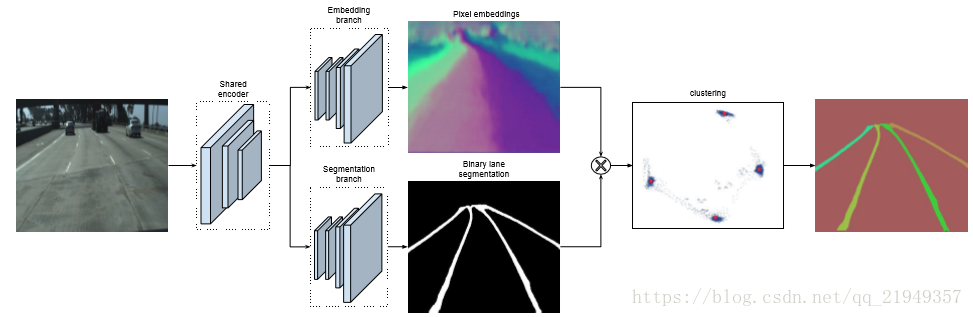
最后，再来拟合每条车道线的数学模型。

## Method
### LaneNet
  首先是主体网络部分，两条分支，**一条分支预测mask，另一条分支给每个lane pixel分配所属lane的id**。
  **binary segmentation**和常规的分割问题一样，没有太多特别的。值得一提的是，无论是车道线还是虚线或者车道线被遮挡的情况，作者在生成ground truth的时候都把它们标注了出来，这样就算对车道线没有完全露出来的情况，网络也可以比较好的学习。 
重点是instance segmentation 分支，这个就是利用了上面提到的那篇文章的设计思路，分支的设计思想和传统统计学习的很多算法都类似，**不同的lane看作不同的类**，而**预测的结果力求类内最小化和类间最大化**。本着这个原则设计了loss函数。
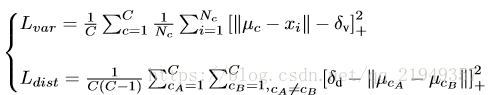
  + **第一项的主要作用就是把属于同一条lane的像素点往一起推，如果像素点和中心点距离超过一定阈值，就会产生loss；**
  + **第二项的作用是把不同类中心点往距离加大的方向拉，如果中心点之间的距离小于一定阈值，就会产生loss（+号的意思代表若大于等于0不变，否则看作0），关于这两个阈值怎么选具体可以看论文，作者的设置和原文有一定的差别。**
  有了这个loss函数，就可以根据lane的mask和不同lane的像素点集合进行训练了。
  
　　**inference的时候思路如下**：随机选取一个lane pixel视作当前lane的点集，然后将周围和它距离小于类内点阈值的所有点视作同一类，然后再遍历其它点，如果有某个点和点集内任意点距离小于类内阈值，则将该点加入点集，重复该过程直到点集不再发生变化，给这些点集分配一个lane的id；然后再选取没有被分配id的任意一个pixel，重复该过程。 
  关于network architecture，作者用的是 encoder-decoder ENet，这个网络共有三个阶段，这两个分支共享前两个阶段，而第三个阶段的encoder和整个网络的decoder部分则是独立。

## curve fitting
**车道线检测一般是给y轴坐标，求车道线上对应的点的x轴的值**。仅仅求出所有lane pixel是不够的，还要进行直线拟合，求出对应的数学模型。一般来说，**现在在拟合曲线时候都会把图像转化到bird’s-eye view角度，就是让车道线都平行，这些便于拟合、可靠性更高，然后求出相应的点后，再映射回来。**
转化到bird’s-eye view是利用矩阵来求的，问题来了，这个矩阵一般是计算一次后就对所有图像都使用的，一个问题就是，如果地平线发生变化，比如汽车行驶在山峦的公路上，很容易产生误差，因此作者就利用一个CNN网络，作者称之为**H-Net**来学习相关参数。 
变换矩阵有6个自由度：
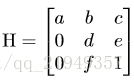
这部分的数学表述参考这里： 
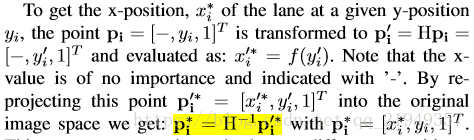
将所有点集构成矩阵，可以写作P’=HP‘，作者拟合的是三次曲线，实验表明三次的效果较好：

拟合曲线的参数求法如下： 
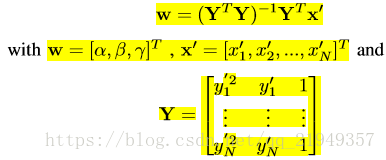
最后，通过标注的点的y坐标求出其x坐标，然后根据求出坐标和实际值之间的差来计算这部分网络的loss，从而对H-Net进行参数更新，以更好地学习变换矩阵：
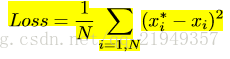

## 实验结果
由于该论文是图森某个比赛的方案，因此关于指标和指标结果就不做介绍了，简单地展示一下结果吧： 
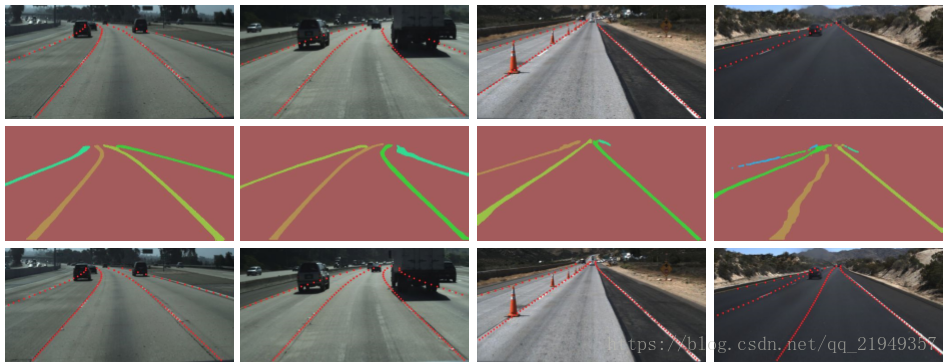
单纯从理论角度来说，笔者认为那篇提出聚类loss的论文其实更有意思，不过在解决实际问题上，这篇文章还是有可取之处，有兴趣的不妨了解学习一下。

## SystemOverview
   如图1所示，对于同一张输入图片，LaneNet输出实例分割的结果，为每个车道线像素分配一个车道线ID，H-Net输出一个转换矩阵H，使用转换矩阵H对车道线像素进行修正，并对修正的结果拟合出一个三阶的多项式作为预测得到的车道线。

## LaneNet
图2  LaneNet的结构
  论文中将**实例分割任务拆解为语义分割和聚类两部分**，如图2所示，LaneNet中decoder分为两个分支，Embedding branch对像素进行嵌入式表示，训练得到的embedding向量用于聚类，Segmentation branch负责对输入图像进行语义分割（对像素进行二分类，判断像素属于车道线还是背景）。最后将两个分支的结果进行结合得到实例分割的结果。

### 语义分割

在设计语义分割模型时，论文主要考虑了以下两个方面：

1. 在构建label时，为了处理遮挡问题，论文对被车辆遮挡的车道线和虚线进行了还原；
2. Loss使用交叉熵，为了解决样本分布不均衡的问题（属于车道线的像素远少于属于背景的像素），参考论文ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation ，使用了boundedinverse class weight对loss进行加权:

图3  bounded inverse class weight  

其中，p为对应类别在总体样本中出现的概率，c是超参数（ENet论文中是1.02，使得权重的取值区间为[1,50]）。

实例分割

  为了区分车道线上的像素属于哪条车道，embedding_branch为每个像素初始化一个embedding向量，并且在设计loss时，使得属于同一条车道线的像素向量距离很小，属于不同车道线的像素向量距离很大。

这部分的loss函数是由两部分组成：方差loss(L_var)和距离loss(L_dist)：

图4  实例分割loss

其中，x_i为像素向量，μ_c为车道线的均值向量，[x]+ = max(0,x)

可以这么理解：

+ 方差loss(L_var) ：当像素向量(pixel embedding)x_i与对应车道线均值向量μ_c的距离大于δ_v时，模型会进行更新，使得x_i 靠近μ_c ；
+ 距离loss(L_dist) ：当不同车道线均值向量 μ_ca和μ_cb之间的距离小于δ_d 时，模型会进行更新，使得μ_ca与μ_cb远离彼此；

也就是说，方差loss(L_var)使得像素向量向车道线的均值向量 μ_c 靠近，距离loss(L_dist)则会推动聚类中心远离彼此。

### 聚类

  为了方便在推理时对像素进行聚类，在图4中实例分割loss中设置δ_d > 6*δ_v。

  在进行聚类时，首先使用mean shift聚类，使得簇中心沿着密度上升的方向移动，防止将离群点选入相同的簇中；之后对像素向量进行划分：以簇中心为圆心，以2δ_v为半径，选取圆中所有的像素归为同一车道线。重复该步骤，直到将所有的车道线像素分配给对应的车道。
  + 只有在推理时才需要对车道线像素进行聚类。
  + 不熟悉mean shift算法的同学可以看看这篇博客：mean shift
### Network Architecture

  LaneNet是基于ENet的encoder-decoder模型，如图5所示，ENet由5个stage组成，其中stage2和stage3基本相同，stage1,2,3属于encoder，stage4,5属于decoder。

  如图2所示，在LaneNet中，语义分割和实例分割两个任务共享stage1和stage2，并将stage3和后面的decoder层作为各自的分支(branch)进行训练；其中，语义分割分支(branch)的输出shape为W*H*2，实例分割分支(branch)的输出shape为W*H*N，W,H分别为原图宽和高，N为embedding vector的维度；两个分支的loss权重相同。
  图5  ENet网络结构

## H-NET
  LaneNet的输出是每条车道线的像素集合，还需要根据这些像素点回归出一条车道线。传统的做法是将图片投影到鸟瞰图中，然后使用2阶或者3阶多项式进行拟合。在这种方法中，转换矩阵H只被计算一次，所有的图片使用的是相同的转换矩阵，这会导致地平面（山地，丘陵）变化下的误差。

  为了解决这个问题，论文训练了一个可以预测转置矩阵H的神经网络H-Net，网络的输入是图片，输出是转置矩阵H：
  + 通过置0对转置矩阵进行约束，即水平线在变换下保持水平。（即坐标y的变换不受坐标x的影响）
由图6可以看出，转置矩阵H只有6个参数，因此H-Net的输出是一个6维的向量。H-Net由6层普通卷积网络和一层全连接网络构成，其网络结构如图7所示：

图7  H-Net网络结构

### 损失函数设计
H-Net的损失函数
Curve Fitting (inference)

Curve fitting的过程就是通过坐标y去重新预测坐标x的过程：

图8  使用转换矩阵进行推理的过程

## 实验超参数设置
LaneNet和H-Net是分别进行训练的。在论文的实验部分，两个模型的参数配置如下所示：

LaneNet：

•    Dataset : Tusimple

•    Embedding dimension = 4

•    δ_v=0.5

•    δ_d=3

•    Image size = 512*256

•    Adam optimizer

•    Learning rate = 5e-4

•    Batch size = 8

H-Net：

•    Dataset : Tusimple

•    3rd-orderpolynomial

•    Image size =128*64

•    Adam optimizer

•    Learning rate = 5e-5

•    Batch size = 10

## 个人总结
1.论文将车道线检测定义为实例分割问题，通过将语义分割和聚类两个任务结合完成了对车道线的实例分割；

2.由于图片中的车道线数量不固定，需用通过聚类的方法来检测出所有的车道线，论文通过embedding branch的loss函数的设计，使用有监督训练解决了像素的聚类问题；

3.LaneNet的网络结构是借鉴ENet的，而ENet是2016年提出的一种语义分割模型，是不是可以使用性能更好的语义分割模型（如deeplab）作为LaneNet的网络结构？

## 语义分割类型
语义分割是计算机视觉领域中的问题，将一些原始数据（例如，平面图像）输入并将它们转换为具有突出明显的感兴趣区域。

分为：

（1）标准语义分割（standard semantic segmentation）

（2）实例感知语义分割（instance aware semantic segmentation）

其中，标准语义分割又称为全像素语义分割（full-pixel semantic segmentation），是它将每个像素分类为属于对象类的过程；

实例感知语义分割，是标准语义分割的子类型，它将每个像素分类为属于对象类以及该类的实体ID；

例如：
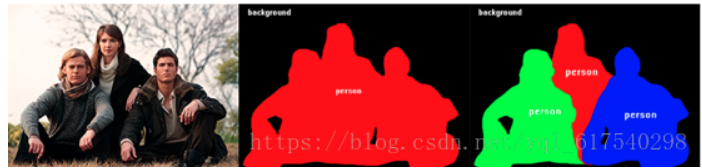
语义分割认为他们都是人；

实例分割认为他们是不同的人，不同的对象。

## codes:

1.https://github.com/MaybeShewill-CV/lanenet-lane-detection

其他车道检测代码：

1.https://blog.csdn.net/weixin_38746685/article/details/81613065

https://github.com/xlwang123/SEU_LaneDetect 

2.advanced_lane_detection

3.LDWS

4.driving-lane-departure-warning

参考文献：

1.https://www.jianshu.com/p/c6d38d648509

2.https://blog.csdn.net/c20081052/article/details/80622722